# Load PAT module and packages

In [1]:
%load_ext autoreload
%autoreload 2
from pat import data, utils
import json, os, glob
import pandas as pd, numpy as np
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style('white')
from tqdm import tqdm

 # Load data into a long dataframe. 

In [9]:
fnames = np.sort(glob.glob('output/json/*_keypoints.json'))
new_df_fname = 'output/Sherlock.csv'
col_names = ['fname', 'frame', 'key','keyID', 'personID','value']
if not os.path.exists(new_df_fname):
    for fname in tqdm(fnames):
        frame_no = os.path.split(fname)[1].split('_')[1]
        utils.load_keypoints(fname, frame_no = frame_no).to_csv(new_df_fname, index=False, header=False, mode='a')
    df = pd.read_csv(new_df_fname, header=None, names=col_names)
else:
    df = pd.read_csv(new_df_fname, header=None, names=col_names)

100%|██████████| 74525/74525 [00:00<00:00, 366921.59it/s]


# Run some examples of manipulations

/Users/jinhyuncheong/Dropbox/Projects_Dartmouth/mind2019/pat/pat/data.py:29: UserWarning: registration of accessor <class 'pat.data.PoseAnalysisToolbox'> under name 'pat' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("pat")


(202616, 6) Keypoints
(199950, 6) Keypoints


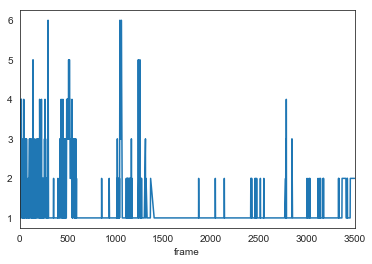

(2018,)
(2666, 75) Pose2D
(2666, 300)
(1113, 75) Pose2D


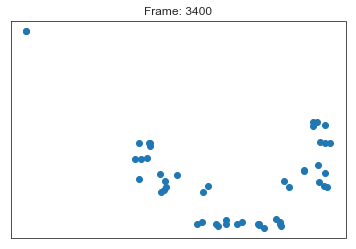

In [16]:
df = pd.read_csv(new_df_fname, header=None, names=col_names)
print(df.shape, df.pat._type)

df = df.pat.grab_pose()
print(df.shape, df.pat._type)

no_people_per_frame = df.pat.grab_people()
no_people_per_frame.plot()
plt.show()
print(no_people_per_frame.shape)

pose_df = df.pat.grab_person_pose() 
print(pose_df.shape, pose_df.pat._type)

rdms = pose_df.pat.extract_distance()
print(rdms.shape)

filtered = pose_df.pat.filter_pose_confidence()
print(filtered.shape, filtered.pat._type)

pose_df.pat.plot(frame_no=3400);

# Plot distance matrix of joints and scatterplot together. 

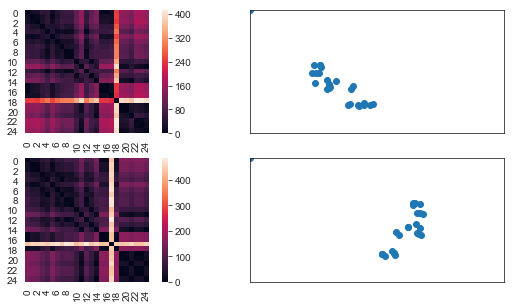

In [17]:
from scipy.spatial.distance import squareform
frame_no = 3400
_df = pose_df.query('frame==@frame_no')
f,axes = plt.subplots(2,2,figsize=(10,5))
for row in range(pose_df.query('frame==3400').shape[0]):
    xs = _df.iloc[row,::3]
    ys = _df.iloc[row,1::3]
    rdm = rdms.query('frame==3400').iloc[row,:]
    sns.heatmap((squareform(rdm)), ax=axes[row, 0], square=True)
    axes[row,1].scatter(xs,ys)
    axes[row,1].axes.set_xscale('linear')
    axes[row,1].axes.set_yscale('linear')
    axes[row,1].set(xlim=[0,640], ylim=[0,360], xticks=[], xticklabels=[], yticklabels=[])
    axes[row,1].set_ylim(axes[row,1].get_ylim()[::-1])

# Example of loading data directly as pose2D format

In [2]:
# Extract keypoints.json files into one composite csv Frame x 75 Keypoints
from pat.data import pose2d_cols
from joblib import Parallel, delayed
fnames = np.sort(glob.glob('output/json/*_keypoints.json'))
new_df_fname = 'output/Sherlock_full_par.csv'
if not os.path.exists(new_df_fname):
    result = Parallel(n_jobs=3)(delayed(utils.load_keypoints_2d)(fname, 
             os.path.split(fname)[1].split('_')[1], new_df_fname) for fname in fnames)
else:
    # Load the data back with multiindex and column names. 
    df = pd.read_csv(new_df_fname, header=None, index_col=[0, 1], names=pose2d_cols)
    df.index.names=['frame','personID']
    df = df.sort_values(['frame','personID'])
    print(df.pat._type)

Pose2D


In [4]:
df.head()

x_Nose   y_Nose    c_Nose   x_Neck   y_Neck    c_Neck  \
frame personID                                                           
0     -1          0.000    0.000  0.000000  388.861  170.712  0.178593   
2     -1          0.000    0.000  0.000000    0.000    0.000  0.000000   
4      0          0.000    0.000  0.000000  427.044  207.869  0.374014   
       1          0.000    0.000  0.000000  387.851  189.299  0.085803   
5      0        434.864  194.178  0.054259  426.987  206.882  0.323331   

                x_RShoulder  y_RShoulder  c_RShoulder  x_RElbow  ...  \
frame personID                                                   ...   
0     -1              0.000        0.000     0.000000     0.000  ...   
2     -1              0.000        0.000     0.000000     0.000  ...   
4      0            437.758      207.861     0.197524   445.567  ...   
       1              0.000        0.000     0.000000     0.000  ...   
5      0            421.134      204.929     0.198052   412.328  ...   

                 c_LHeel  x_RBigToe  y_RBigToe  c_RBigToe  x_RSmallToe  \
frame personID                                                           
0     -1        0.076256      0.000      0.000   0.000000        0.000   
2     -1        0.000000      0.000      0.000   0.000000        0.000   
4      0        0.197993    420.164    293.963   0.305509      417.214   
       1        0.128814    400.584    261.686   0.115762        0.000   
5      0        0.213562    420.153    293.011   0.394928      418.182   

                y_RSmallToe  c_RSmallToe  x_RHeel  y_RHeel   c_RHeel  
frame personID                                                        
0     -1              0.000     0.000000    0.000    0.000  0.000000  
2     -1              0.000     0.000000    0.000    0.000  0.000000  
4      0            294.927     0.295303  410.339  290.050  0.262129  
       1              0.000     0.000000  395.717  256.805  0.142757  
5      0            293.963     0.348930  403.518  286.151  0.316106  

[5 rows x 75 columns]

# Example of interactive plotting widget

In [ ]:
%matplotlib notebook
df.pat.plot_interactive()

# Load standard figure

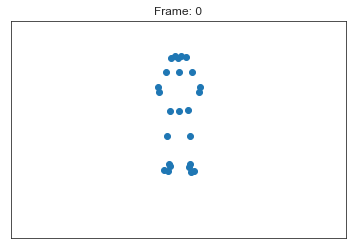

In [3]:
from pat.utils import get_resource_path
standardfig = pd.read_csv(os.path.join(get_resource_path(),'standardfig.csv'),index_col=['frame'])
standardfig.pat.plot(frame_no=0, xlim=[0,640], ylim=[0,480])

# Align example

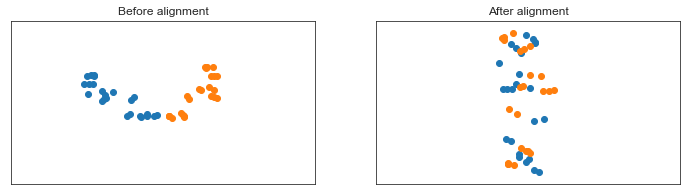

In [4]:
# reload data just in case you skipped
from pat.data import pose2d_cols
new_df_fname = 'output/Sherlock_full_par.csv'
df = pd.read_csv(new_df_fname, header=None, index_col=[0, 1], names=pose2d_cols)
df.index.names=['frame','personID']
df = df.sort_values(['frame','personID'])
    
dfnan = df.replace({0.0:np.nan}).iloc[2446:2448,:]
aligned = dfnan.pat.align()

f,axes=plt.subplots(1,2,figsize=(12,3))
for rowix, row in dfnan.iterrows():
    row.to_frame().T.pat.plot(ax=axes[0], xlim=[0,640], ylim=[0,480], title="Before alignment")
for rowix, row in aligned.iterrows():
    row.to_frame().T.pat.plot(ax=axes[1], xlim=[-1,1], ylim=[-.5,.5], title="After alignment")
plt.axis('equal');

# impute example

100%|██████████| 1/1 [00:00<00:00, 58.37it/s]


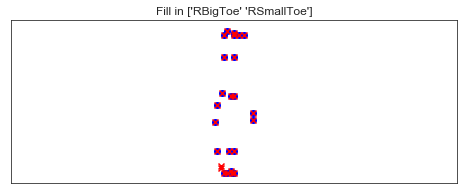

In [25]:
dfnan = df.replace({0.0:np.nan}).iloc[222:223,:]
missing_labels = np.unique([col.split('_')[-1] for col in dfnan.columns.values[dfnan.isna().values[0]]])
imputed = dfnan.pat.impute()
f,ax=plt.subplots(figsize=(8,3))
for rowix, row in dfnan.iterrows():
    row.to_frame().T.pat.plot(ax=ax, xlim=None, ylim=None, color='b')
for rowix, row in imputed.iterrows():
    row.to_frame().T.pat.plot(ax=ax, xlim=None, ylim=None, color ='r', marker='x', title=f"Fill in {missing_labels}")
plt.axis('equal');

# Extract distance between all limb pairs for two people


100%|██████████| 52/52 [00:00<00:00, 283.73it/s]


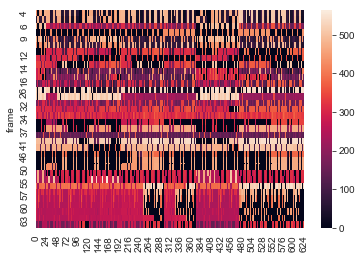

In [7]:
out = df.iloc[:100,:].pat.extract_person_distance()
sns.heatmap(out)
plt.show()